# Metrics

In [12]:
from tensorflow.keras import backend as K 
def decode_mask(mask, label_mapping):
    # Get unique labels in the mask
    unique_labels = tf.unique(tf.reshape(mask, [-1]))[0]
    
    # Initialize an empty tensor for the decoded mask
    decoded_mask = tf.zeros_like(mask, dtype=tf.uint8)

    # Loop through the label mapping and assign colors to corresponding class indices
    for label, color in label_mapping.items():
        # Create a mask where mask equals the label
        label_mask = tf.equal(mask, label)
        # Convert the color to a tensor
        color_tensor = tf.constant(color, dtype=tf.uint8)
        # Expand dimensions to match the shape of mask
        expanded_color = tf.expand_dims(tf.expand_dims(color_tensor, axis=0), axis=0)
        # Multiply the color with the mask and assign to decoded_mask
        decoded_mask = tf.where(label_mask, expanded_color, decoded_mask)
    print(decoded_mask)
    return decoded_mask
def iou_score(y_pred, y_true, smooth=1):
    print(y_true.shape)
    
    y_true = tf.reshape(tf.squeeze(y_true), [-1,120*120])
    print(y_true.shape)
    print(y_pred)
    y_pred=tf.math.argmax(y_pred,axis=-1)
    y_pred=decode_mask(y_pred,inverse_label_mapping)
    y_pred = tf.reshape(tf.squeeze(y_pred), [-1,120*120])
    print(y_pred.shape)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
label_mapping = {
    (250, 235, 185): 0,  # Informal Settlements
    (200, 200, 200): 1,  # Built-Up
    (100, 100, 150): 2,  # Impervious Surfaces
    (80, 140, 50): 3,    # Vegetation
    (200, 160, 40): 4,   # Barren
    (40, 120, 240): 5,   # Water
    (0, 0, 0): 6         # Unlabelled
}

# Inverse mapping to convert class indices back to RGB values
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
def mean_iou(predict, true):
    predict = tf.argmax(predict, axis=-1)
    true = tf.argmax(true, axis=-1)
    return keras.metrics.MeanIoU(num_classes=7)(predict, true)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **UNET Implementation**

In [2]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
import cv2

# Label mapping from RGB values to class indices
label_mapping = {
    (250, 235, 185): 0,  # Informal Settlements
    (200, 200, 200): 1,  # Built-Up
    (100, 100, 150): 2,  # Impervious Surfaces
    (80, 140, 50): 3,    # Vegetation
    (200, 160, 40): 4,   # Barren
    (40, 120, 240): 5,   # Water
    (0, 0, 0): 6         # Unlabelled
}

# Inverse mapping to convert class indices back to RGB values
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Model configuration
input_shape = (128, 128, 3)
num_labels = len(label_mapping)


# Define data preprocessing functions
def preprocess_image(image_path, target_size=(128,128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array 

def load_dataset(data_path):
    images = []
    masks = []
    i = 0
    n = len(glob.glob(os.path.join(data_path, 'images', '*.tif')))
    for image_file in tqdm(glob.glob(os.path.join(data_path, 'images', '*.tif'))):
        mask_file = os.path.join(data_path, 'masks', os.path.basename(image_file).replace('.tif', '.png'))
        images.append(preprocess_image(image_file))
     
        
        masks.append(preprocess_mask(mask_file))

    return np.array(images),np.array(masks)


import cv2
import numpy as np

def preprocess_mask(mask_path, num_classes=7, tolerance=10):
    # Read the mask image
    mask = cv2.imread(mask_path)

#     # Convert the image to RGB if it's in BGR format
    if mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

#     # Initialize an empty array for the encoded mask
    encoded_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    # Define color codes for each class
    class_colors = [
        [250, 235, 185],  # Informal Settlements
        [200, 200, 200],  # Built-Up
        [100, 100, 150],  # Impervious Surfaces
        [80, 140, 50],    # Vegetation
        [200, 160, 40],   # Barren
        [40, 120, 240],   # Water
        [0, 0, 0]         # Unlabelled
    ]

    # Loop through the class colors and encode the mask
    for class_id, color in enumerate(class_colors):
        # Use a tolerance range for color matching
        class_mask = np.all(np.abs(mask - color) <= 0, axis=-1)
        encoded_mask[class_mask] = class_id
    #print(encoded_mask.shape)
    #Adding below code for transformer training 
    encoded_mask_resized = cv2.resize(encoded_mask, (128, 128), interpolation=cv2.INTER_NEAREST)

    return encoded_mask_resized
#     return encoded_mask


train_images, train_masks = load_dataset('/kaggle/input/mumbai/Prepared_Dataset/train')

val_images, val_masks = load_dataset('/kaggle/input/mumbai/Prepared_Dataset/val')



100%|██████████| 891/891 [00:10<00:00, 81.04it/s]


In [3]:

# Define the U-Net model
def create_unet_model(input_shape, num_labels):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up1 = tf.keras.layers.UpSampling2D(size=(2, 2))(pool3)
    concat1 = tf.keras.layers.concatenate([conv3, up1], axis=-1)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat1)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)

    up2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = tf.keras.layers.concatenate([conv2, up2], axis=-1)
    conv5 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv5 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up3 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    concat3 = tf.keras.layers.concatenate([conv1, up3], axis=-1)
    conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat3)
    conv6 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    # Output layer
    outputs = tf.keras.layers.Conv2D(7, 1, activation='softmax')(conv6)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

# Initialize the U-Net model
model = create_unet_model(input_shape, num_labels)

In [4]:
import tensorflow as tf
from keras import backend as K
# Define IoU metric
from keras import backend as K

# def jacard_coef(y_true, y_pred):
#     print(y_pred)
    
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

import keras.backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)
def jacard_loss(y_true, y_pred):
    return 1.0 - jacard_coef(y_true, y_pred)
model.compile(
    metrics=[jacard_coef],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     # Add IoU as a metric
)
early_stop = EarlyStopping(
    
    monitor='val_jacard_loss',
    min_delta=0,
    patience=10,
    restore_best_weights=True,
    verbose=1
)
# Train the U-Net model
history = model.fit(
    x=train_images, y=train_masks,
    validation_data=(val_images, val_masks),
    epochs=30,
    batch_size=16,
    callbacks=early_stop
)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


446/446 [==============================] - 76s 146ms/step - loss: 1.1417 - jacard_coef: 0.3922 - val_loss: 0.8273 - val_jacard_coef: 0.4812
Epoch 2/30
446/446 [==============================] - 65s 146ms/step - loss: 0.6564 - jacard_coef: 0.6093 - val_loss: 0.5632 - val_jacard_coef: 0.6602
Epoch 3/30
446/446 [==============================] - 66s 147ms/step - loss: 0.4925 - jacard_coef: 0.7082 - val_loss: 0.7020 - val_jacard_coef: 0.6292
Epoch 4/30
446/446 [==============================] - 66s 147ms/step - loss: 0.4317 - jacard_coef: 0.7414 - val_loss: 0.4082 - val_jacard_coef: 0.7493
Epoch 5/30
446/446 [==============================] - 66s 147ms/step - loss: 0.4149 - jacard_coef: 0.7500 - val_loss: 0.4113 - val_jacard_coef: 0.7450
Epoch 6/30
446/446 [==============================] - 66s 147ms/step - loss: 0.3695 - jacard_coef: 0.7729 - val_loss: 0.3478 - val_jacard_coef: 0.7877
Epoch 7/30
446/446 [==============================] - 66s 147ms/step - loss: 0.3448 - jacard_coef: 0.7864

In [16]:
def preprocess_mask(mask_path, num_classes=7):
    mask = cv2.imread(mask_path)

    if mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    encoded_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    class_colors = [
        [250, 235, 185],
        [200, 200, 200],
        [100, 100, 150],
        [80, 140, 50],
        [200, 160, 40],
        [40, 120, 240],
        [0, 0, 0]
    ]

    for class_id, color in enumerate(class_colors):
        class_mask = np.all(mask == color, axis=-1)
        encoded_mask[class_mask] = class_id

    return encoded_mask

In [5]:
model.save('/kaggle/working/unet_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from keras import backend as K
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    # Check if the union is zero to avoid division by zero
    if np.sum(union) == 0:
        return 0
    
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

# Function to calculate mIoU for a set of masks
def calculate_miou(y_true_list, y_pred_list):
    iou_scores = [calculate_iou(y_true, y_pred) for y_true, y_pred in zip(y_true_list, y_pred_list)]
    return np.mean(iou_scores)

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(120, 120)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Function to preprocess a mask
def preprocess_mask(mask_path, num_classes=7):
    mask = cv2.imread(mask_path)

    if mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    encoded_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    class_colors = [
        [250, 235, 185],
        [200, 200, 200],
        [100, 100, 150],
        [80, 140, 50],
        [200, 160, 40],
        [40, 120, 240],
        [0, 0, 0]
    ]

    for class_id, color in enumerate(class_colors):
        class_mask = np.all(mask == color, axis=-1)
        encoded_mask[class_mask] = class_id

    return encoded_mask

# Function to test all images in the test folder
def test_all_images(test_folder, model):
    test_images_folder = os.path.join(test_folder, 'images')
    test_masks_folder = os.path.join(test_folder, 'masks')

    image_paths = sorted(os.listdir(test_images_folder))
    true_masks = [preprocess_mask(os.path.join(test_masks_folder, img.replace('.tif', '.png'))) for img in image_paths]
    predicted_masks = []
    iou_scores = []

    for img_path in image_paths:
        image_path = os.path.join(test_images_folder, img_path)
        image = preprocess_single_image(image_path)
        predicted_mask = model.predict(image)[0]
        predicted_mask = np.argmax(predicted_mask, axis=-1)
        predicted_masks.append(predicted_mask)

        # Calculate IoU for the current image
        true_mask = preprocess_mask(os.path.join(test_masks_folder, img_path.replace('.tif', '.png')))
        iou = calculate_iou(true_mask, predicted_mask)
        iou_scores.append(iou)

    # Calculate mIoU
    miou = calculate_miou(true_masks, predicted_masks)
    print(f"Mean IoU across all images: {miou}")

    

# Load your segmentation model
# Replace 'your_model_path' with the actual path to your trained model
#loaded_model = load_model('/kaggle/working/unet_model.h5')
loaded_model=tf.keras.models.load_model('/kaggle/working/unet_model.h5', custom_objects={'jacard_coef':                   
jacard_coef})
# Test all images in the test folder
test_folder_path = '/kaggle/input/mumbai/Prepared_Dataset/train'
test_all_images(test_folder_path, loaded_model)



1/1 [==============================] - 0s 20ms/step
Mean IoU across all images: 0.9542142542052652


(120, 120)
[[3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]
(120, 120, 3)
1/1 [==============================] - 0s 432ms/step
[[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 3 3 5]
 ...
 [5 5 5 ... 3 3 3]
 [5 5 5 ... 3 3 3]
 [5 5 5 ... 3 3 3]]
(120, 120)
(120, 120, 3)


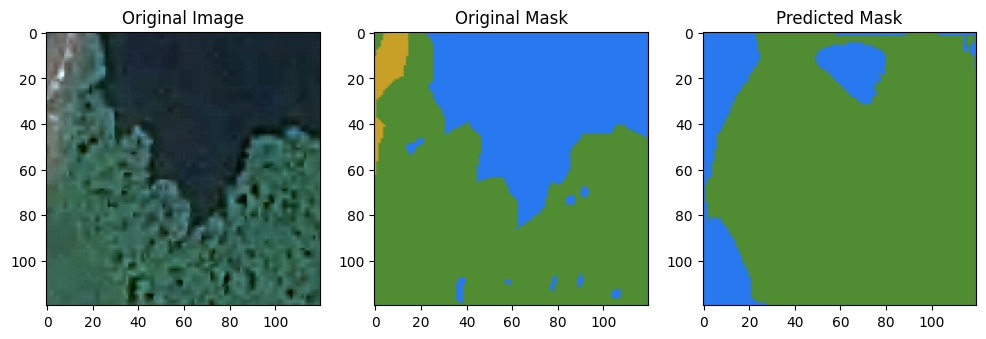

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved U-Net model
saved_model_path = '/kaggle/working/attunet_model.h5'
loaded_model=tf.keras.models.load_model('/kaggle/working/unet_model.h5', custom_objects={'jacard_coef':                   
jacard_coef})

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(120, 120)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)
def decode_mask(mask, label_mapping):
    # Initialize an empty array for the decoded mask
    decoded_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Loop through the label mapping and assign colors to corresponding class indices
    for label, color in label_mapping.items():
        decoded_mask[mask == label] = color

    return decoded_mask
# Function to plot the original and predicted masks for a single image
def plot_masks(image_path, model):
    image = preprocess_single_image(image_path)
    original_mask = preprocess_mask('/kaggle/input/mumbai/Prepared_Dataset/train/masks/tile_1.29_8.png')
    print(original_mask.shape)
    print(original_mask)
    original_mask = decode_mask(original_mask, inverse_label_mapping)
    print(original_mask.shape)
#     print("orginal mask :",original_mask)
    # Predict the mask using the U-Net model
    predicted_mask = model.predict(image)[0]
    
    predicted_mask = np.argmax(predicted_mask, axis=-1)
    print(predicted_mask)
    print(predicted_mask.shape)
    predicted_mask = decode_mask(predicted_mask, inverse_label_mapping)
    print(predicted_mask.shape)
#     print("predicted mask :",predicted_mask)
    # Plot the original and predicted masks side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(load_img(image_path, target_size=(120, 120)))
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='viridis')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='viridis')
    plt.title('Predicted Mask')

    plt.show()

# Test an example image
test_image_path = '/kaggle/input/mumbai/Prepared_Dataset/train/images/tile_1.29_8.tif'
plot_masks(test_image_path, loaded_model)


# Attention UNET

In [ ]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import multiply, add, Activation, BatchNormalization
from tensorflow.keras.models import Model



# Label mapping from RGB values to class indices
label_mapping = {
    (250, 235, 185): 0,  # Informal Settlements
    (200, 200, 200): 1,  # Built-Up
    (100, 100, 150): 2,  # Impervious Surfaces
    (80, 140, 50): 3,    # Vegetation
    (200, 160, 40): 4,   # Barren
    (40, 120, 240): 5,   # Water
    (0, 0, 0): 6         # Unlabelled
}

# Inverse mapping to convert class indices back to RGB values
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Model configuration
input_shape = (120, 120, 3)
num_labels = len(label_mapping)
# Inputs

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = L.Conv2D(7, 1, padding="same", activation="softmax")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

model = attention_unet(input_shape)

import keras.backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

model.compile(
    metrics=["accuracy",jacard_coef],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     # Add IoU as a metric
)
early_stop = EarlyStopping(
    
    monitor='val_jacard_coef',
    min_delta=0,
    patience=15,
    restore_best_weights=True,
    verbose=1
)
# Train the U-Net model
history = model.fit(
    x=train_images, y=train_masks,
    validation_data=(val_images, val_masks),
    epochs=30,
    batch_size=32,
    callbacks=early_stop
)# Save the trained U-Net model
model.save('/kaggle/working/attunet_model.h5')


Epoch 1/30
223/223 [==============================] - 141s 522ms/step - loss: 0.6507 - accuracy: 0.7961 - jacard_coef: 0.6685 - val_loss: 2.9573 - val_accuracy: 0.3126 - val_jacard_coef: 0.1874
Epoch 2/30
223/223 [==============================] - 104s 465ms/step - loss: 0.4380 - accuracy: 0.8557 - jacard_coef: 0.7495 - val_loss: 1.8204 - val_accuracy: 0.4434 - val_jacard_coef: 0.2869
Epoch 3/30
223/223 [==============================] - 104s 465ms/step - loss: 0.3935 - accuracy: 0.8682 - jacard_coef: 0.7685 - val_loss: 0.5983 - val_accuracy: 0.7855 - val_jacard_coef: 0.6494
Epoch 4/30
223/223 [==============================] - 104s 464ms/step - loss: 0.3531 - accuracy: 0.8807 - jacard_coef: 0.7883 - val_loss: 0.3987 - val_accuracy: 0.8555 - val_jacard_coef: 0.7483
Epoch 5/30
223/223 [==============================] - 103s 464ms/step - loss: 0.3178 - accuracy: 0.8923 - jacard_coef: 0.8066 - val_loss: 0.2978 - val_accuracy: 0.8979 - val_jacard_coef: 0.8156
Epoch 6/30
223/223 [==========

In [33]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from keras import backend as K
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    # Check if the union is zero to avoid division by zero
    if np.sum(union) == 0:
        return 0
    
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

# Function to calculate mIoU for a set of masks
def calculate_miou(y_true_list, y_pred_list):
    iou_scores = [calculate_iou(y_true, y_pred) for y_true, y_pred in zip(y_true_list, y_pred_list)]
    return np.mean(iou_scores)

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(120, 120)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Function to preprocess a mask
def preprocess_mask(mask_path, num_classes=7):
    mask = cv2.imread(mask_path)

    if mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    encoded_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    class_colors = [
        [250, 235, 185],
        [200, 200, 200],
        [100, 100, 150],
        [80, 140, 50],
        [200, 160, 40],
        [40, 120, 240],
        [0, 0, 0]
    ]

    for class_id, color in enumerate(class_colors):
        class_mask = np.all(mask == color, axis=-1)
        encoded_mask[class_mask] = class_id

    return encoded_mask

# Function to test all images in the test folder
def test_all_images(test_folder, model):
    test_images_folder = os.path.join(test_folder, 'images')
    test_masks_folder = os.path.join(test_folder, 'masks')

    image_paths = sorted(os.listdir(test_images_folder))
    true_masks = [preprocess_mask(os.path.join(test_masks_folder, img.replace('.tif', '.png'))) for img in image_paths]
    predicted_masks = []
    iou_scores = []

    for img_path in image_paths:
        image_path = os.path.join(test_images_folder, img_path)
        image = preprocess_single_image(image_path)
        predicted_mask = model.predict(image)[0]
        predicted_mask = np.argmax(predicted_mask, axis=-1)
        predicted_masks.append(predicted_mask)

        # Calculate IoU for the current image
        true_mask = preprocess_mask(os.path.join(test_masks_folder, img_path.replace('.tif', '.png')))
        iou = calculate_iou(true_mask, predicted_mask)
        iou_scores.append(iou)

    # Calculate mIoU
    miou = calculate_miou(true_masks, predicted_masks)
    print(f"Mean IoU across all images: {miou}")

    

# Load your segmentation model
# Replace 'your_model_path' with the actual path to your trained model
#loaded_model = load_model('/kaggle/working/unet_model.h5')
loaded_model=tf.keras.models.load_model('/kaggle/working/attunet_model1.h5', custom_objects={'jacard_coef':                   
jacard_coef})
# Test all images in the test folder
test_folder_path = '/kaggle/input/mumbai/Prepared_Dataset/test'
test_all_images(test_folder_path, loaded_model)



1/1 [==============================] - 0s 21ms/step
Mean IoU across all images: 0.8874317517579005


In [1]:

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

In [ ]:
print(iou_scores)

**# Swin U-Net**

In [1]:
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# util_layers

In [2]:

from __future__ import absolute_import

import tensorflow as tf
from tensorflow.keras.layers import Layer

def drop_path_(inputs, drop_prob, is_training):
    
    # Bypass in non-training mode
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    input_shape = tf.shape(inputs)
    batch_num = input_shape[0]; rank = len(input_shape)
    
    shape = (batch_num,) + (1,) * (rank - 1)
    random_tensor = keep_prob + tf.random.uniform(shape, dtype=inputs.dtype)
    path_mask = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * path_mask
    return output

class drop_path(Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path_(x, self.drop_prob, training)

# Swin_layers

In [3]:

from __future__ import absolute_import

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization
from tensorflow.keras.activations import softmax



def window_partition(x, window_size):
    
    # Get the static shape of the input tensor
    # (Sample, Height, Width, Channel)
    _, H, W, C = x.get_shape().as_list()
    
    # Subset tensors to patches
    patch_num_H = H//window_size
    patch_num_W = W//window_size
    x = tf.reshape(x, shape=(-1, patch_num_H, window_size, patch_num_W, window_size, C))
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    
    # Reshape patches to a patch sequence
    windows = tf.reshape(x, shape=(-1, window_size, window_size, C))
    
    return windows

def window_reverse(windows, window_size, H, W, C):
    
    # Reshape a patch sequence to aligned patched 
    patch_num_H = H//window_size
    patch_num_W = W//window_size
    x = tf.reshape(windows, shape=(-1, patch_num_H, patch_num_W, window_size, window_size, C))
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    
    # Merge patches to spatial frames
    x = tf.reshape(x, shape=(-1, H, W, C))
    
    return x



class Mlp(tf.keras.layers.Layer):
    def __init__(self, filter_num, drop=0., name=''):
        
        super().__init__()
        
        # MLP layers
        self.fc1 = Dense(filter_num[0], name='{}_mlp_0'.format(name))
        self.fc2 = Dense(filter_num[1], name='{}_mlp_1'.format(name))
        
        # Dropout layer
        self.drop = Dropout(drop)
        
        # GELU activation
        self.activation = tf.keras.activations.gelu
        
    def call(self, x):
        
        # MLP --> GELU --> Drop --> MLP --> Drop
        x = self.fc1(x)
        self.activation(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        
        return x

class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0, proj_drop=0., name=''):
        super().__init__()
        
        self.dim = dim # number of input dimensions
        self.window_size = window_size # size of the attention window
        self.num_heads = num_heads # number of self-attention heads
        
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5 # query scaling factor
        
        self.prefix = name
        
        # Layers
        self.qkv = Dense(dim * 3, use_bias=qkv_bias, name='{}_attn_qkv'.format(self.prefix))
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name='{}_attn_proj'.format(self.prefix))
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        
        # zero initialization
        num_window_elements = (2*self.window_size[0] - 1) * (2*self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight('{}_attn_pos'.format(self.prefix),
                                                            shape=(num_window_elements, self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)
        
        # Indices of relative positions
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing='ij')
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        
        # convert to the tf variable
        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False, name='{}_attn_pos_ind'.format(self.prefix))
        
        self.built = True

    def call(self, x, mask=None):
        
        # Get input tensor static shape
        _, N, C = x.get_shape().as_list()
        head_dim = C//self.num_heads
        
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        
        # Query rescaling
        q = q * self.scale
        
        # multi-headed self-attention
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = (q @ k)
        
        # Shift window
        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape=(-1,))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias, shape=(num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=(-1, nW, self.num_heads, N, N)) + mask_float
            attn = tf.reshape(attn, shape=(-1, self.num_heads, N, N))
            attn = softmax(attn, axis=-1)
        else:
            attn = softmax(attn, axis=-1)
        
        # Dropout after attention
        attn = self.attn_drop(attn)
        
        # Merge qkv vectors
        x_qkv = (attn @ v)
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, N, C))
        
        # Linear projection
        x_qkv = self.proj(x_qkv)
        
        # Dropout after projection
        x_qkv = self.proj_drop(x_qkv)
        
        return x_qkv

class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_patch, num_heads, window_size=7, shift_size=0, num_mlp=1024,
                 qkv_bias=True, qk_scale=None, mlp_drop=0, attn_drop=0, proj_drop=0, drop_path_prob=0, name=''):
        super().__init__()
        
        self.dim = dim # number of input dimensions
        self.num_patch = num_patch # number of embedded patches; a tuple of  (heigh, width)
        self.num_heads = num_heads # number of attention heads
        self.window_size = window_size # size of window
        self.shift_size = shift_size # size of window shift
        self.num_mlp = num_mlp # number of MLP nodes
        self.prefix = name
        
        # Layers
        self.norm1 = LayerNormalization(epsilon=1e-5, name='{}_norm1'.format(self.prefix))
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop, name=self.prefix)
        self.drop_path = drop_path(drop_path_prob)
        self.norm2 = LayerNormalization(epsilon=1e-5, name='{}_norm2'.format(self.prefix))
        self.mlp = Mlp([num_mlp, dim], drop=mlp_drop, name=self.prefix)
        
        # Assertions
        assert 0 <= self.shift_size, 'shift_size >= 0 is required'
        assert self.shift_size < self.window_size, 'shift_size < window_size is required'
        
        # <---!!!
        # Handling too-small patch numbers
        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)
            
    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.num_patch
            h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None))
            
            # attention mask
            mask_array = np.zeros((1, H, W, 1))
            
            ## initialization
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)
            
            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False, name='{}_attn_mask'.format(self.prefix))
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        
        # Checking num_path and tensor sizes
        assert L == H * W, 'Number of patches before and after Swin-MSA are mismatched.'
        
        # Skip connection I (start)
        x_skip = x
        
        # Layer normalization
        x = self.norm1(x)
        
        # Convert to aligned patches
        x = tf.reshape(x, shape=(-1, H, W, C))

        # Cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # Window partition 
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, C))

        # Window-based multi-headed self-attention
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # Merge windows
        attn_windows = tf.reshape(attn_windows, shape=(-1, self.window_size, self.window_size, C))
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # Reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
            
        # Convert back to the patch sequence
        x = tf.reshape(x, shape=(-1, H*W, C))

        # Drop-path
        ## if drop_path_prob = 0, it will not drop
        x = self.drop_path(x)
        
        # Skip connection I (end)
        x = x_skip +  x
        
        # Skip connection II (start)
        x_skip = x
        
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        
        # Skip connection II (end)
        x = x_skip + x

        return x
    

# Transformer_layers

In [4]:

from __future__ import absolute_import

import tensorflow as tf
from tensorflow.image import extract_patches
from tensorflow.keras.layers import Conv2D, Layer, Dense, Embedding

class patch_extract(Layer):

    
    def __init__(self, patch_size):
        super(patch_extract, self).__init__()
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]
        
    def call(self, images):
        
        batch_size = tf.shape(images)[0]
        
        patches = extract_patches(images=images,
                                  sizes=(1, self.patch_size_x, self.patch_size_y, 1),
                                  strides=(1, self.patch_size_x, self.patch_size_y, 1),
                                  rates=(1, 1, 1, 1), padding='VALID',)
        # patches.shape = (num_sample, patch_num, patch_num, patch_size*channel)
        
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        patches = tf.reshape(patches, (batch_size, patch_num*patch_num, patch_dim))
        # patches.shape = (num_sample, patch_num*patch_num, patch_size*channel)
        
        return patches
    
class patch_embedding(Layer):
    
    
    def __init__(self, num_patch, embed_dim):
        super(patch_embedding, self).__init__()
        self.num_patch = num_patch
        self.proj = Dense(embed_dim)
        self.pos_embed = Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        embed = self.proj(patch) + self.pos_embed(pos)
        return embed

class patch_merging(tf.keras.layers.Layer):
   
    def __init__(self, num_patch, embed_dim, name=''):
        super().__init__()
        
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        
        # A linear transform that doubles the channels 
        self.linear_trans = Dense(2*embed_dim, use_bias=False, name='{}_linear_trans'.format(name))

    def call(self, x):
        
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        
        assert (L == H * W), 'input feature has wrong size'
        assert (H % 2 == 0 and W % 2 == 0), '{}-by-{} patches received, they are not even.'.format(H, W)
        
        # Convert the patch sequence to aligned patches
        x = tf.reshape(x, shape=(-1, H, W, C))
        
        # Downsample
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        
        # Convert to the patch squence
        x = tf.reshape(x, shape=(-1, (H//2)*(W//2), 4*C))
       
        # Linear transform
        x = self.linear_trans(x)

        return x

class patch_expanding(tf.keras.layers.Layer):

    def __init__(self, num_patch, embed_dim, upsample_rate, return_vector=True, name=''):
        super().__init__()
        
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.upsample_rate = upsample_rate
        self.return_vector = return_vector
        
        # Linear transformations that doubles the channels 
        self.linear_trans1 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        # 
        self.linear_trans2 = Conv2D(upsample_rate*embed_dim, kernel_size=1, use_bias=False, name='{}_linear_trans1'.format(name))
        self.prefix = name
        
    def call(self, x):
        
        H, W = self.num_patch
        B, L, C = x.get_shape().as_list()
        
        assert (L == H * W), 'input feature has wrong size'

        x = tf.reshape(x, (-1, H, W, C))
        
        x = self.linear_trans1(x)
        
        # rearange depth to number of patches
        x = tf.nn.depth_to_space(x, self.upsample_rate, data_format='NHWC', name='{}_d_to_space'.format(self.prefix))
        
        if self.return_vector:
            # Convert aligned patches to a patch sequence
            x = tf.reshape(x, (-1, L*self.upsample_rate*self.upsample_rate, C//2))

        return x

# Utils

In [5]:

import numpy as np
from PIL import Image

def dummy_loader(model_path):
 
    backbone = keras.models.load_model(model_path, compile=False)
    W = backbone.get_weights()
    return W

def image_to_array(filenames, size, channel):
   
    
    # number of files
    L = len(filenames)
    
    # allocation
    out = np.empty((L, size, size, channel))
    
    # loop over filenames
    if channel == 1:
        for i, name in enumerate(filenames):
            with Image.open(name) as pixio:
                pix = pixio.resize((size, size), Image.NEAREST)
                out[i, ..., 0] = np.array(pix)
    else:
        for i, name in enumerate(filenames):
            with Image.open(name) as pixio:
                pix = pixio.resize((size, size), Image.NEAREST)
                out[i, ...] = np.array(pix)[..., :channel]
    return out[:, ::-1, ...]

def shuffle_ind(L):

    
    ind = np.arange(L)
    np.random.shuffle(ind)
    return ind

def freeze_model(model, freeze_batch_norm=False):
    
    if freeze_batch_norm:
        for layer in model.layers:
            layer.trainable = False
    else:
        from tensorflow.keras.layers import BatchNormalization    
        for layer in model.layers:
            if isinstance(layer, BatchNormalization):
                layer.trainable = True
            else:
                layer.trainable = False
    return model

In [6]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of Swin-UNET.
    
    The general structure:
    
    1. Input image --> a sequence of patches --> tokenize these patches
    2. Downsampling: swin-transformer --> patch merging (pooling)
    3. Upsampling: concatenate --> swin-transfprmer --> patch expanding (unpooling)
    4. Model head
    
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
#     transformer_layers=transformer_layers()
    # Patch extraction
    X = patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    
    X =patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)
    
    return X


In [7]:
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 4         # number of Swin Transformers per downsampling level
stack_num_up = 4         # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

In [8]:
# Input section
input_size = (128, 128, 3)
IN = Input(input_size)

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, 
                      shift_window=shift_window, name='swin_unet')

In [9]:
# Output section
n_labels = 7
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)

# Model configuration
model = Model(inputs=[IN,], outputs=[OUT,])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 patch_extract (patch_extra  (None, 1024, 48)             0         ['input_1[0][0]']             
 ct)                                                                                              
                                                                                                  
 patch_embedding (patch_emb  (None, 1024, 128)            137344    ['patch_extract[0][0]']       
 edding)                                                                                          
                                                                                              

In [22]:
import keras.backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

model.compile(
    metrics=["accuracy",jacard_coef],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
     # Add IoU as a metric
)
early_stop = EarlyStopping(
    
    monitor='val_jacard_coef',
    min_delta=0,
    patience=15,
    restore_best_weights=True,
    verbose=1
)
# Train the U-Net model
history = model.fit(
    x=train_images, y=train_masks,
    validation_data=(val_images, val_masks),
    epochs=50,
    batch_size=32,
    callbacks=early_stop
)# Save the trained U-Net model
model.save('/kaggle/working/seg.h5')


Epoch 1/50
223/223 [==============================] - 244s 671ms/step - loss: 0.5365 - accuracy: 0.8106 - jacard_coef: 0.6839 - val_loss: 0.4897 - val_accuracy: 0.8280 - val_jacard_coef: 0.7073
Epoch 2/50
223/223 [==============================] - 141s 631ms/step - loss: 0.4343 - accuracy: 0.8481 - jacard_coef: 0.7380 - val_loss: 0.4972 - val_accuracy: 0.8340 - val_jacard_coef: 0.7162
Epoch 3/50
223/223 [==============================] - 140s 630ms/step - loss: 0.4865 - accuracy: 0.8306 - jacard_coef: 0.7148 - val_loss: 0.4146 - val_accuracy: 0.8520 - val_jacard_coef: 0.7430
Epoch 4/50
223/223 [==============================] - 140s 629ms/step - loss: 0.3600 - accuracy: 0.8728 - jacard_coef: 0.7753 - val_loss: 0.3879 - val_accuracy: 0.8676 - val_jacard_coef: 0.7669
Epoch 5/50
223/223 [==============================] - 141s 630ms/step - loss: 0.3274 - accuracy: 0.8844 - jacard_coef: 0.7939 - val_loss: 0.4734 - val_accuracy: 0.8401 - val_jacard_coef: 0.7256
Epoch 6/50
223/223 [==========

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from keras import backend as K
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    # Check if the union is zero to avoid division by zero
    if np.sum(union) == 0:
        return 0
    
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.reshape(y_pred, (-1, 7)) # Reshape to (num_pixels, 7)
    y_pred_f = K.one_hot(K.argmax(y_pred_f, axis=-1), num_classes=7) # Convert to one-hot
    y_pred_f = K.flatten(y_pred_f)
    
    # Reshape y_true_f to match the shape of y_pred_f
    y_true_f = K.one_hot(K.cast(y_true_f, 'int32'), num_classes=7) # Convert to one-hot
    y_true_f = K.flatten(y_true_f)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

# Function to calculate mIoU for a set of masks
def calculate_miou(y_true_list, y_pred_list):
    iou_scores = [calculate_iou(y_true, y_pred) for y_true, y_pred in zip(y_true_list, y_pred_list)]
    return np.mean(iou_scores)

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Function to preprocess a mask
def preprocess_mask(mask_path, num_classes=7):
    mask = cv2.imread(mask_path)

    if mask.shape[2] == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    encoded_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    class_colors = [
        [250, 235, 185],
        [200, 200, 200],
        [100, 100, 150],
        [80, 140, 50],
        [200, 160, 40],
        [40, 120, 240],
        [0, 0, 0]
    ]

    for class_id, color in enumerate(class_colors):
        class_mask = np.all(mask == color, axis=-1)
        encoded_mask[class_mask] = class_id

    encoded_mask_resized = cv2.resize(encoded_mask, (128, 128), interpolation=cv2.INTER_NEAREST)

    return encoded_mask_resized

# Function to test all images in the test folder
def test_all_images(test_folder, model):
    test_images_folder = os.path.join(test_folder, 'images')
    test_masks_folder = os.path.join(test_folder, 'masks')

    image_paths = sorted(os.listdir(test_images_folder))
    true_masks = [preprocess_mask(os.path.join(test_masks_folder, img.replace('.tif', '.png'))) for img in image_paths]
    predicted_masks = []
    iou_scores = []

    for img_path in image_paths:
        image_path = os.path.join(test_images_folder, img_path)
        image = preprocess_single_image(image_path)
        predicted_mask = model.predict(image)[0]
        predicted_mask = np.argmax(predicted_mask, axis=-1)
        predicted_masks.append(predicted_mask)

        # Calculate IoU for the current image
        true_mask = preprocess_mask(os.path.join(test_masks_folder, img_path.replace('.tif', '.png')))
        iou = calculate_iou(true_mask, predicted_mask)
        iou_scores.append(iou)

    # Calculate mIoU
    miou = calculate_miou(true_masks, predicted_masks)
    print(f"Mean IoU across all images: {miou}")

    # Print the mask paths with IoU between 0.85 and 0.95
    for i, iou in enumerate(iou_scores):
        if 0.98 <= iou <= 1.0:
            print(f"Mask path: {os.path.join(test_masks_folder, image_paths[i].replace('.tif', '.png'))}, IoU: {iou}")

# Load your segmentation model
# Replace 'your_model_path' with the actual path to your trained model
#loaded_model = load_model('/kaggle/working/unet_model.h5')
loaded_model=tf.keras.models.load_model('/kaggle/working/seg.h5', custom_objects={'jacard_coef':                   
jacard_coef,'patch_extract':patch_extract,'patch_embedding':patch_embedding,'SwinTransformerBlock':SwinTransformerBlock,'patch_merging':patch_merging,'patch_expanding':patch_expanding})
# Test all images in the test folder
test_folder_path = '/kaggle/input/mumbai/Prepared_Dataset/test'
test_all_images(test_folder_path, loaded_model)



1/1 [==============================] - 0s 78ms/step
Mean IoU across all images: 0.9129874394177057
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_1.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_10.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_11.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_12.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_13.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_14.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_15.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_16.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_17.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_Dataset/test/masks/jp22_1.0_18.png, IoU: 1.0
Mask path: /kaggle/input/mumbai/Prepared_D

# Visualization of Results

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved U-Net model
saved_model_path = '/kaggle/input/seg.h5/keras/seg/1'
loaded_model=tf.keras.models.load_model('/kaggle/input/seg.h5/keras/seg/1', custom_objects={'jacard_coef':                   
jacard_coef})

# Function to preprocess a single image
def preprocess_single_image(image_path, target_size=(120, 120)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)
def decode_mask(mask, label_mapping):
    # Initialize an empty array for the decoded mask
    decoded_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Loop through the label mapping and assign colors to corresponding class indices
    for label, color in label_mapping.items():
        decoded_mask[mask == label] = color

    return decoded_mask
# Function to plot the original and predicted masks for a single image
def plot_masks(image_path, model):
    image = preprocess_single_image(image_path)
    original_mask = preprocess_mask('/kaggle/input/mumbai/Prepared_Dataset/train/masks/tile_1.29_8.png')
    print(original_mask.shape)
    print(original_mask)
    original_mask = decode_mask(original_mask, inverse_label_mapping)
    print(original_mask.shape)
#     print("orginal mask :",original_mask)
    # Predict the mask using the U-Net model
    predicted_mask = model.predict(image)[0]
    
    predicted_mask = np.argmax(predicted_mask, axis=-1)
    print(predicted_mask)
    print(predicted_mask.shape)
    predicted_mask = decode_mask(predicted_mask, inverse_label_mapping)
    print(predicted_mask.shape)
#     print("predicted mask :",predicted_mask)
    # Plot the original and predicted masks side by side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(load_img(image_path, target_size=(120, 120)))
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='viridis')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='viridis')
    plt.title('Predicted Mask')

    plt.show()

# Test an example image
test_image_path = '/kaggle/input/uploads/uploads/1.tif'
plot_masks(test_image_path, loaded_model)
